# Kinematic chain in a plane (2D)

Marcos Duarte

Kinematic chain refers to an assembly of rigid bodies (links) connected by joints that is the mathematical model for a mechanical system which in turn can represent a biological system such as the human arm ([Wikipedia](http://en.wikipedia.org/wiki/Kinematic_chain)). 

Let's analyze the kinematics of such a chain, more precisely, the case for a planar two-link kinematic chain. There are different ways to describe the kinematics of a chain, for now we will use simple trigonometry and calculus and the Cartesian coordinate system. This approach is simpler  and more intuitive but it gets too complicated for a kinematic chain with many links or in the 3D space. For such more complicated problems, it would be recommended using rigid transformations (see, for example, Siciliano et al. (2009)). 

We will deduce the kinematic properties of kinematic chains algebraically using [Sympy](http://sympy.org/), a Python library for symbolic mathematics. In Sympy, we could even use the [mechanics module](http://docs.sympy.org/latest/modules/physics/mechanics/index.html), a specific module for creation of symbolic equations of motion for complicated multibody systems, but let's deduce everythig manually to understand all the details.

## Properties of kinematic chains

For a kinematic chain, the base is the extremity (origin) of a kinematic chain which is typically considered attached to the ground, body or fixed. The endpoint is the other extremity (end) of a kinematic chain and typically can move. In robotics, the term end-effector is used and usually refers to a last link (rigid body) in this chain. 

In topological terms, a kinematic chain is termed open when there is only one sequence of links connecting the two ends of the chain. Otherwise it's termed closed and in this case a sequence of links forms a loop. A kinematic chain can be classified as serial or parallel or a mixed of both. In a serial chain the links are connected in a serial order. A serial chain is an open chain, otherwise it is a parallel chain or a branched chain (e.g., hand and fingers). 

Another important term to characterize a kinematic chain is degree of freedom (DOF). In mechanics, the degree of freedom of a mechanical system is the number of independent parameters that define its configuration or that determine the state of a physical system. A particle in the 3D space has three DOFs because we need three coordinates to specify its position. A rigid body in the 3D space has six DOFs because we need three coordinates of one point at the body and three angles to completely define the configuration of the rigid body. For a link attached to a fixed body by a revolute joint in a plane, all we need to define the configuration of the link is one angle and then this link has only one DOF. A kinematic chain with two links in a plane has two DOFs, and so on.

The mobility of a kinematic chain is its total number of degrees of freedom. The redundancy of a kinematic chain is its mobility minus the number of degrees of freedom of the endpoint.

## The kinematics of one-link system

First, let's study the case of a system composed by one planar revolute joint and one link, which technically it's not a chain but it will be useful to review (or introduce) key concepts.

<div class='center-align'><figure><img src="./../images/onelink.png" width=450 alt="onelink"/><figcaption><center><i>One link attached to a fixed body by a revolute joint in a plane.</i></center></figcaption> </figure></div>

First, let's import the necessary libraries from Python and its ecosystem:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, Math

from sympy import Symbol, symbols, Function, Matrix, simplify, lambdify, expand, latex
from sympy import diff, cos, sin, sqrt, acos, atan2, atan
from sympy.physics.mechanics import dynamicsymbols, mlatex, init_vprinting
init_vprinting()

import sys
sys.path.insert(1, r'./../functions')  # add to pythonpath

We need to define the symbolic variables, $t$, $\ell$, $\alpha$ (and make $\alpha$ a function of time):

In [2]:
t = Symbol('t')
l = Symbol('ell', positive=True)
a = dynamicsymbols('alpha')  # it's already alpha(t)

Using simple trigonometry, the equations for the endpoint position in terms of the joint angle are:

In [3]:
rx = l*cos(a)
display(Math(latex(r'r_x=') + latex(rx)))
ry = l*sin(a)
display(Math(latex(r'r_y=') + latex(ry)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Computing the configuration of a link or a chain (including the endpoint location) from the the joint parameters (joint angles and link lengths) as we have done is called forward or direct kinematics.

The inverse kinematics for this system is to specify the joint angle in terms of the endpoint position. For the one-link system:

$$\alpha = arctan\left(\frac{r_y}{r_x}\right)$$

The mathematical manipulation will be easier if we use the matrix formalism (and let's drop the explicit dependence on t):

In [4]:
r = Matrix((rx, ry))
Math(latex(r'\mathbf{r}=\begin{bmatrix} r_x \\ r_y \\ \end{bmatrix}=' + mlatex(r)))

<IPython.core.display.Math object>

## Differential kinematics

Differential kinematics gives the relationship between the joint velocities and the corresponding endpoint linear velocity. This mapping is described by a matrix, termed [Jacobian](http://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant), which depends on the kinematic chain configuration and it is of great use in the study of kinematic chains. First, let's deduce the endpoint velocity without using the Jacobian and then we will see how to calculate the endpoint velocity using the Jacobian.

The velocity of the endpoint can be obtained by the first-order [derivative](http://en.wikipedia.org/wiki/Derivative) of the position vector. The derivative of a vector is obtained by differentiating each vector component:   

$$ \frac{\mathrm{d}\mathbf{r}}{\mathrm{d}t} = \begin{bmatrix}
\frac{\mathrm{d}r_x}{\mathrm{d}t} \\
\frac{\mathrm{d}r_y}{\mathrm{d}t} \\
\end{bmatrix} $$   

Note that the derivative is with respect to time but $r_x$ and $r_y$ depend explicitly on $\alpha$ and it's $\alpha$ that depends on $t$ ($r_x$ and $r_y$ depend implicitly on $t$). To calculate this type of derivative we will use the [chain rule](http://en.wikipedia.org/wiki/Chain_rule).  

<br>
<div style="background-color:#FBFBEF;border:1px solid black;padding:10px;"> 
**[Chain rule](http://en.wikipedia.org/wiki/Chain_rule)**   
For variable $f$ which is function of variable $g$ which in turn is function of variable $t$, $f(g(t))$ or $(f\circ g)(t)$, the derivative of $f$  with respect to $t$ is (using [Lagrange's notation](http://en.wikipedia.org/wiki/Notation_for_differentiation)):   
<br />
$$(f\circ g)^{'}(t) = f'(g(t)) \cdot g'(t)$$   

Or using what is known as [Leibniz's notation](http://en.wikipedia.org/wiki/Notation_for_differentiation):   
<br />
$$\frac{\mathrm{d}f}{\mathrm{d}t} = \frac{\mathrm{d}f}{\mathrm{d}g} \cdot \frac{\mathrm{d}g}{\mathrm{d}t}$$   

If $f$ is function of two other variables which both are function of $t$, $ f(x(t),y(t))$, the chain rule for this case is:   
<br />
$$\frac{\mathrm{d}f}{\mathrm{d}t} = \frac{\partial f}{\partial x} \cdot \frac{\mathrm{d}x}{\mathrm{d}t} + \frac{\partial f}{\partial y} \cdot \frac{\mathrm{d}y}{\mathrm{d}t}$$   

Where $df/dt$ represents the [total derivative](http://en.wikipedia.org/wiki/Total_derivative) and $\partial f / \partial x$ represents the [partial derivative](http://en.wikipedia.org/wiki/Partial_derivative) of a function.   
<br />
[**Product rule**](http://en.wikipedia.org/wiki/Product_rule)   
The derivative of the product of two functions is:   
<br />
$$ (f \cdot g)' = f' \cdot g + f \cdot g'  $$

</div>

For the planar one-link case, the linear velocity of the endpoint is:

In [5]:
v = r.diff(t)
Math(mlatex('\mathbf{v}=') + mlatex(v))

<IPython.core.display.Math object>

Where we used the [Newton's notation](http://en.wikipedia.org/wiki/Notation_for_differentiation) for differentiation. Note that $\dot{\alpha}$ represents the unknown angular velocity of the joint; this is why the derivative of $\alpha$ is not explicitly solved. 
The magnitude or [Euclidian norm](http://en.wikipedia.org/wiki/Vector_norm) of the vector $\mathbf{v}$ is:

$$ ||\mathbf{v}||=\sqrt{v_x^2+v_y^2} $$

In [6]:
Math(mlatex(r'||\mathbf{v}||=') + mlatex(simplify(sqrt(v[0]**2+v[1]**2))))

<IPython.core.display.Math object>

Which is $\ell\dot{\alpha}$ (we could have used the function norm of Sympy, v.norm(), but the output does not symplify nicely).   

The direction of $\mathbf{v}$ is tangent to the circular trajectory of the endpoint as can be seen in the figure below.

<div class='center-align'><figure><img src="./../images/onelinkVel.png" width=400 alt="onelinkVel"/><figcaption><center><i>Endpoint velocity of one link attached to a fixed body by a revolute joint in a plane.</i></center></figcaption></figure></div>

The acceleration of the endpoint position can be given by the second-order derivative of the position or by the first-order derivative of the velocity. Using the chain and product rules for differentiation, the linear acceleration of the endpoint is:

In [7]:
acc = r.diff(t, 2)
Math(mlatex(r'\mathbf{a}=') + mlatex(acc))

<IPython.core.display.Math object>

Examining the terms of the expression for the linear acceleration, we see there are two types of them: the term (in each direction) proportional to the angular acceleration $\ddot{\alpha}$ and other term proportional to the square of the angular velocity $\dot{\alpha}^{2}$.    
The term proportional to angular acceleration is always tangent to the trajectory of the endpoint (see figure below) and it's magnitude or Euclidean norm is:

In [8]:
A = a.diff(t, 2)
Math(mlatex(r'||\mathbf{a}_t||=') +
     mlatex(simplify(sqrt(expand(acc[0]).coeff(A)**2+expand(acc[1]).coeff(A)**2)*A)))

<IPython.core.display.Math object>

The term proportional to angular velocity always points to the joint, the center of the circular motion (see figure below), because of that this term is termed [centripetal acceleration](http://en.wikipedia.org/wiki/Centripetal_acceleration#Tangential_and_centripetal_acceleration). Its magnitude is:

In [9]:
A = a.diff(t)**2
Math(mlatex(r'||\mathbf{a}_c||=') +
     mlatex(simplify(sqrt(expand(acc[0]).coeff(A)**2+expand(acc[1]).coeff(A)**2)*A)))

<IPython.core.display.Math object>

This means that there will be a linear acceleration even if the angular acceleration is zero because although the magnitude of the linear velocity is constant in this case, its direction varies (due to the centripetal acelleration).

<div class='center-align'><figure><img src="./../images/onelinkAcc.png" width=400 alt="onelinkAcc"/><figcaption><center><i>Endpoint tantential and centripetal acceleration terms of one link attached to a fixed body by a revolute joint in a plane.</i></center></figcaption> </figure></div>

Let's plot some simulated data to have an idea of the one-link kinematics. Consider $\ell=1\:m,\alpha_0=0^o,\alpha_f=90^o $, and $1\:s$ of movement duration, and that it is a [minimum-jerk movement](http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/MinimumJerkHypothesis.ipynb).

In [10]:
a0, af, d = 0, np.pi/2, 1
ts = np.arange(0, 1.01, .01)
mjt  = a0 + (af - a0)*(10*(t/d)**3 - 15*(t/d)**4 + 6*(t/d)**5)

ang  = lambdify(t, mjt, 'numpy'); ang = ang(ts)
vang = lambdify(t, mjt.diff(t,1), 'numpy'); vang = vang(ts)
aang = lambdify(t, mjt.diff(t,2), 'numpy'); aang = aang(ts)
jang = lambdify(t, mjt.diff(t,3), 'numpy'); jang = jang(ts)

b,c,d,e = symbols('b c d e')
dicti = {l:1, a:b, a.diff(t, 1):c, a.diff(t, 2):d, a.diff(t, 3):e}

r2 = r.subs(dicti);
rxfu = lambdify(b, r2[0], modules = 'numpy')
ryfu = lambdify(b, r2[1], modules = 'numpy')

v2 = v.subs(dicti);
vxfu = lambdify((b, c), v2[0], modules = 'numpy')
vyfu = lambdify((b, c), v2[1], modules = 'numpy')

acc2 = acc.subs(dicti);
axfu = lambdify((b, c, d), acc2[0], modules = 'numpy')
ayfu = lambdify((b, c, d), acc2[1], modules = 'numpy')

jerk = r.diff(t,3)
jerk2 = jerk.subs(dicti);
jxfu = lambdify((b, c, d, e), jerk2[0], modules = 'numpy')
jyfu = lambdify((b, c, d, e), jerk2[1], modules = 'numpy')

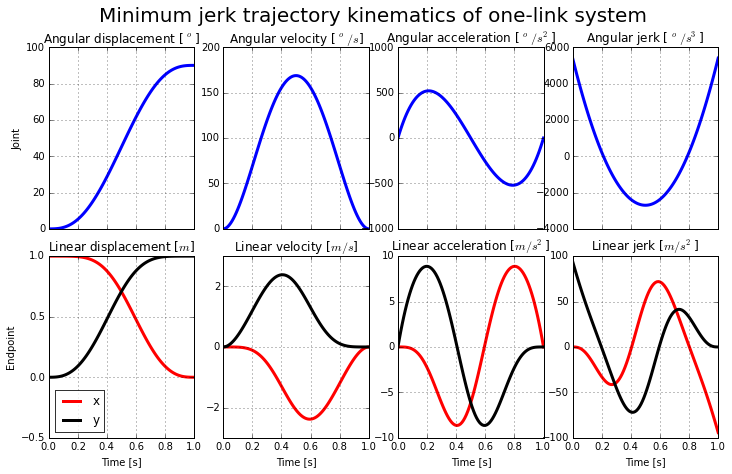

In [11]:
fig, hax = plt.subplots(2, 4, sharex = True, figsize=(12, 7))
hax[0, 0].plot(ts,ang*180/np.pi, linewidth=3)
hax[0, 0].set_title('Angular displacement [ $^o$]');
hax[0, 0].set_ylabel('Joint')
hax[0, 1].plot(ts,vang*180/np.pi, linewidth=3)
hax[0, 1].set_title('Angular velocity [ $^o/s$]');
hax[0, 2].plot(ts,aang*180/np.pi, linewidth=3)
hax[0, 2].set_title('Angular acceleration [ $^o/s^2$]');
hax[0, 3].plot(ts,jang*180/np.pi, linewidth=3)
hax[0, 3].set_title('Angular jerk [ $^o/s^3$]');
hax[1, 0].plot(ts,rxfu(ang), 'r', linewidth=3, label = 'x')
hax[1, 0].plot(ts,ryfu(ang), 'k', linewidth=3, label = 'y')
hax[1, 0].set_xlabel('Time [s]'); 
hax[1, 0].set_title('Linear displacement [$m$]');
hax[1, 0].legend(loc='best').get_frame().set_alpha(0.8)
hax[1, 0].set_ylabel('Endpoint')
hax[1, 1].plot(ts,vxfu(ang,vang), 'r', linewidth=3)
hax[1, 1].plot(ts,vyfu(ang,vang), 'k', linewidth=3)
hax[1, 1].set_xlabel('Time [s]'); 
hax[1, 1].set_title('Linear velocity [$m/s$]');
hax[1, 2].plot(ts,axfu(ang,vang,aang), 'r', linewidth=3)
hax[1, 2].plot(ts,ayfu(ang,vang,aang), 'k', linewidth=3)
hax[1, 2].set_xlabel('Time [s]'); 
hax[1, 2].set_title('Linear acceleration [$m/s^2$]');
hax[1, 3].plot(ts,jxfu(ang,vang,aang,jang), 'r', linewidth=3)
hax[1, 3].plot(ts,jyfu(ang,vang,aang,jang), 'k', linewidth=3)
hax[1, 3].set_xlabel('Time [s]'); 
hax[1, 3].set_title('Linear jerk [$m/s^2$]');
fig.suptitle('Minimum jerk trajectory kinematics of one-link system', fontsize=20);
for hax2 in hax.flat:
        hax2.locator_params(nbins=5)
        hax2.grid()
plt.subplots_adjust(hspace=0.15) #plt.tight_layout()

<br>
<div style="background-color:#FBFBEF;border:1px solid black;padding:10px;"> 
**[Jacobian](http://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant)**     
In the context of kinematic chains, the Jacobian is a matrix of all first-order partial derivatives of the linear position vector of the endpoint with respect to the angular position vector.  
The Jacobian for a kinematic chain relates differential changes in the joint angle vector with the resulting differential changes in the linear position vector of the endpoint.  
In a general form, the Jacobian is:   
<br />
$$ \mathbf{J}= 
\begin{bmatrix}
\frac{\partial F_{1}}{\partial q_{1}} & ... & \frac{\partial F_{1}}{\partial q_{n}} \\
\vdots  & \ddots  & \vdots \\ 
\frac{\partial F_{m}}{\partial q_{1}} & ... & \frac{\partial F_{m}}{\partial q_{n}} \\ 
\end{bmatrix} $$   

For a kinematic chain, the function $F_{i}$ is the expression of the endpoint position in $m$ cartesian coordinates and the variable $q_{i}$ is the angle of each $n$ joints.  
</div>

For the planar one-link case, the Jacobian is:

$$ \mathbf{J}= 
\begin{bmatrix}
\frac{\partial \:r_x}{\partial \alpha} \\
\frac{\partial \:r_y}{\partial \alpha} \\
\end{bmatrix} $$

In [12]:
r = Matrix((rx, ry))
J = r.diff(a)
Math(mlatex(r'\mathbf{J}=') + mlatex(J))

<IPython.core.display.Math object>

And Sympy has a function to calculate the Jacobian:

In [13]:
J = r.jacobian([a])
Math(mlatex(r'\mathbf{J}=') + mlatex(J))

<IPython.core.display.Math object>

The linear velocity of the end-effector is given by the product between the Jacobian of the kinematic link and the angular velocity:

$$ \mathbf{v} = \mathbf{J} \cdot \mathbf{\omega} $$

Where:

In [14]:
w = Matrix([a.diff(t)])
Math(mlatex(r'\mathbf{\omega}=') + mlatex(w))

<IPython.core.display.Math object>

The angular velocity is also a vector; it's direction is perpendicular to the plane of rotation and using the [right-hand rule](http://en.wikipedia.org/wiki/Right-hand_rule) this direction is the same as of the vector z coming out of the screen (paper).   

Then:

In [15]:
velJ = J*w
Math(mlatex(r'\mathbf{v_J}=') + mlatex(velJ))

<IPython.core.display.Math object>

And the linear acceleration of the endpoint is given by the derivative of this product:
 
$$ \mathbf{a} = \dot{\mathbf{J}} \cdot \mathbf{\omega} + \mathbf{J} \cdot \dot{\mathbf{\omega}} $$

Let's calculate this derivative:

In [16]:
accJ = J.diff(t)*w + J*w.diff(t)
Math(mlatex(r'\mathbf{a_J}=') + mlatex(accJ))

<IPython.core.display.Math object>

These two expressions derived with the Jacobian are the same as the direct derivatives of the equation for the endpoint position.

## The kinematics of a two-link chain

We now will look at the case of a planar kinematic chain with two links, as shown below. The deduction will be similar to the case with one link we just saw.

<div class='center-align'><figure><img src="./../images/twolinks.png" width=450 alt="twolinks"/><figcaption><center><i>Kinematics of a two-link chain with revolute joints in a plane.</i></center></figcaption> </figure></div>

We need to define the symbolic variables $t,\:\ell_1,\:\ell_2,\:\alpha_1,\:\alpha_2$ (and make $\alpha_1$ and $\alpha_2$ function of time):

In [17]:
t = Symbol('t')
l1, l2 = symbols('ell_1 ell_2', positive=True)
#a1, a2 = Function(r'\alpha_1')(t), Function(r'\alpha_2')(t)
a1, a2 = dynamicsymbols('alpha1 alpha2')  # alpha1(t) alpha2(t)

The position of the endpoint in terms of the joint angle is:

In [18]:
r2 = Matrix((l1*cos(a1)+l2*cos(a1+a2),l1*sin(a1)+l2*sin(a1+a2)))
Math(mlatex(r'\mathbf{r}=\begin{bmatrix} r_x \\ r_y \end{bmatrix}=') + mlatex(r2))

<IPython.core.display.Math object>

Note that $\alpha_2$ is a joint angle (referred as measured in the joint space); the angle of the segment 2 with respect to the horizontal is $\alpha_1+\alpha_2$ and is referred as an angle in the segmental space.   

The inverse kinematics of this system is to specify the joint angles in terms of the endpoint position. Using the [cosine rule](http://en.wikipedia.org/wiki/Law_of_cosines), the angle $\alpha_2$ is:

$$ r_x^2+r_y^2=\ell_1^2+\ell_2^2-2\ell_1 \ell_2 cos(\pi-\alpha_2) $$

$$ \alpha_2=arccos\left(\frac{r_x^2+r_y^2-\ell_1^2-\ell_2^2}{2\ell_1 \ell_2}\;\;\right) $$

To find the angle $\alpha_1$, if we now look at the triangle in red in the figure below, its angle $\phi$ is:

$$\phi=arctan\left(\frac{\ell_2 sin(\alpha_2)}{\ell_1+\ell_2 cos(\alpha_2)}\right) $$

And the angle of its hypotenuse with the horizontal is:

$$ \alpha_1+\phi=arctan\left(\frac{r_y}{r_x}\right) $$

Then, the angle $\alpha_1$ is:

$$ \alpha_1=arctan\left(\frac{r_y}{r_x}\right) - arctan\left(\frac{\ell_2 sin(\alpha_2)}{\ell_1+\ell_2 cos(\alpha_2)}\right) $$

Note that there are two possible sets of $(\alpha_1,\alpha_2)$ angles for the same $(r_x,r_y)$ coordinate that satisfy the equations above. The figure below shows in orange another possible configuration of the kinematic chain with the same endpoint coordinate. The other solution is $\alpha_2'=2\pi-\alpha_2$, but $sin(\alpha_2')=-sin(\alpha_{2})$ and then the $arctan()$ term in the last equation becomes negative.   
Even for a simple two-link chain we already have a problem of redundancy, there is more than one joint configuration for the same endpoint position; this will be much more problematic for chains with more links (more degrees of freedom).

<div class='center-align'><figure><img src="./../images/twolinksIK.png" width=450 alt="twolinksIK"/><figcaption><center><i>Indetermination in the inverse kinematics approach to determine one of the joint angles for a two-link chain with revolute joints in a plane.</i></center></figcaption> </figure></div>

## Differential kinematics 

The linear velocity of the endpoint is:

In [19]:
vel2 = r2.diff(t)
Math(mlatex(r'\mathbf{v}=') + mlatex(vel2))

<IPython.core.display.Math object>

The linear velocity of the endpoint is the sum of the velocities at each joint, i.e., it is the velocity of the endpoint in relation to joint 2, for example, $\ell_2cos(\alpha_1+\alpha_2)\dot{\alpha}_1$, plus the velocity of joint 2 in relation to joint 1, for example, $\ell_1\dot{\alpha}_1 cos(\alpha_1)$, and this last term we already saw for the one-link example. In classical mechanics this is known as [relative velocity](http://en.wikipedia.org/wiki/Relative_velocity), an example of [Galilean transformation](http://en.wikipedia.org/wiki/Galilean_transformation).

The linear acceleration of the endpoint is:

In [20]:
acc2 = r2.diff(t, 2)
Math(mlatex(r'\mathbf{a}=') + mlatex(acc2))

<IPython.core.display.Math object>

We can separate the equation above for the linear acceleration in three types of terms: proportional to $\ddot{\alpha}$ and to $\dot{\alpha}^2$, as we already saw for the one-link case, and a new term, proportional to $\dot{\alpha}_1\dot{\alpha}_2$:

In [21]:
acc2 = acc2.expand()
A = a1.diff(t, 2)
B = a2.diff(t, 2)
tg = A*Matrix((acc2[0].coeff(A),acc2[1].coeff(A)))+B*Matrix((acc2[0].coeff(B),acc2[1].coeff(B)))

A = a1.diff(t)**2
B = a2.diff(t)**2
ct = A*Matrix((acc2[0].coeff(A),acc2[1].coeff(A)))+B*Matrix((acc2[0].coeff(B),acc2[1].coeff(B)))

A = a1.diff(t)*a2.diff(t)
co = A*Matrix((acc2[0].coeff(A),acc2[1].coeff(A)))

display(Math(mlatex(r'Tangential:\:') + mlatex(tg)))
display(Math(mlatex(r'Centripetal:') + mlatex(ct)))
display(Math(mlatex(r'Coriolis:\;\;\;\;\:') + mlatex(co)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

This new term is called the [Coriolis acceleration](http://en.wikipedia.org/wiki/Coriolis_effect); it is 'felt' by the endpoint when its distance to the instantaneous center of rotation varies, due to the links' constraints, and as consequence the endpoint motion is deflected (its direction is perpendicular to the relative linear velocity of the endpoint with respect to the linear velocity at the second joint, $\mathbf{v} - \mathbf{v}_{joint2}$.

Let's now deduce the Jacobian for this planar two-link chain:

$$ \mathbf{J}= 
\begin{bmatrix}
\frac{\partial r_x}{\partial \alpha_{1}} & \frac{\partial r_x}{\partial \alpha_{2}} \\
\frac{\partial r_y}{\partial \alpha_{1}} & \frac{\partial r_y}{\partial \alpha_{2}} \\
\end{bmatrix} $$

We could manually run `J = Matrix([[r2[0].diff(a1), r2[0].diff(a2)], [r2[1].diff(a1), r2[1].diff(a2)]])`, but it's shorter with the Sympy Jacobian function:

In [22]:
J2 = r2.jacobian([a1, a2])
Math(mlatex(r'\mathbf{J}=') + mlatex(J2))

<IPython.core.display.Math object>

Using the Jacobian, the linear velocity of the endpoint is:   

$$ \mathbf{v_J} = \mathbf{J} \cdot \mathbf{\omega} $$ 

Where:

In [23]:
w2 = Matrix((a1, a2)).diff(t)
Math(mlatex(r'\mathbf{\omega}=') + mlatex(w2))

<IPython.core.display.Math object>

Then:

In [24]:
vel2J = J2*w2
Math(mlatex(r'\mathbf{v_J}=') + mlatex(vel2J))

<IPython.core.display.Math object>

This expression derived with the Jacobian is the same as the first-order derivative  of the equation for the endpoint position. We can show this equality by comparing the two expressions with Sympy:

In [25]:
vel2.expand() == vel2J.expand()

True

Once again, the linear acceleration of the endpoint is given by the derivative of the product between the Jacobian and the angular velocity:
 
$$ \mathbf{a} = \dot{\mathbf{J}} \cdot \mathbf{\omega} + \mathbf{J} \cdot \dot{\mathbf{\omega}} $$

Let's calculate this derivative:

In [26]:
acc2J = J2.diff(t)*w2 + J2*w2.diff(t)
Math(mlatex(r'\mathbf{a_J}=') + mlatex(acc2J))

<IPython.core.display.Math object>

Once again, the expression above is the same as the second-order derivative of the equation for the endpoint position:

In [27]:
acc2.expand() == acc2J.expand()

True

Let's plot some simulated data to have an idea of the two-link kinematics.  
Consider $\ell_1=\ell_2=0.5m, \alpha_1(0)=\alpha_2(0)=0$, 1 s of movement duration, $\alpha_1(1)=\alpha_2(1)=90^o$, and that it is a [minimum-jerk movement](http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/MinimumJerkHypothesis.ipynb) of the endpoint.   

First, the simulated trajectories:

In [28]:
t, p0, pf, d, rx, ry = symbols('t p0 pf d rx ry')

# minimum jerk kinematics
mjt = p0 + (pf-p0)*(10*(t/d)**3 - 15*(t/d)**4 + 6*(t/d)**5)
rfu = lambdify((t, p0, pf, d), mjt, 'numpy')
vfu = lambdify((t, p0, pf, d), diff(mjt, t, 1), 'numpy')
afu = lambdify((t, p0, pf, d), diff(mjt, t, 2), 'numpy')
jfu = lambdify((t, p0, pf, d), diff(mjt, t, 3), 'numpy')

#initial values:
p0, pf, d, L1, L2 = [1, 0], [0.5, .5], 1, .5, .5
ts = np.arange(0, 1.01, .01)

#endpoint kinematics
x  = rfu(ts, p0[0], pf[0],d)
y  = rfu(ts, p0[1], pf[1], d)
vx = vfu(ts, p0[0], pf[0],d)
vy = vfu(ts, p0[1], pf[1], d)
ax = afu(ts, p0[0], pf[0],d)
ay = afu(ts, p0[1], pf[1], d)
jx = jfu(ts, p0[0], pf[0],d)
jy = jfu(ts, p0[1], pf[1], d)

#inverse kinematics
ang2b = np.arccos((x**2+y**2-L1**2-L2**2)/(2*L1*L2))
ang1b = np.arctan2(y,x) - (np.arctan2(L2*np.sin(ang2b),(L1+L2*np.cos(ang2b))))

ang2 = acos((rx**2+ry**2-l1**2-l2**2)/(2*l1*l2))
ang2fu = lambdify((rx,ry,l1,l2), ang2, 'numpy');
ang2 = ang2fu(x,y,L1,L2)
ang1 = atan2(ry,rx) - (atan(l2*sin(acos((rx**2+ry**2-l1**2-l2**2)/(2*l1*l2)))/ \
                            (l1+l2*cos(acos((rx**2+ry**2-l1**2-l2**2)/(2*l1*l2))))))
ang1fu = lambdify((rx,ry,l1,l2), ang1, 'numpy');
ang1 = ang1fu(x,y,L1,L2)

rx = rx(t); ry = ry(t)
ang2b = acos((rx**2+ry**2-l1**2-l2**2)/(2*l1*l2))
ang1b = atan2(ry,rx) - (atan(l2*sin(acos((rx**2+ry**2-l1**2-l2**2)/(2*l1*l2)))/ \
                            (l1+l2*cos(acos((rx**2+ry**2-l1**2-l2**2)/(2*l1*l2))))))
X,Y,Xd,Yd,Xdd,Ydd,Xddd,Yddd = symbols('X Y Xd Yd Xdd Ydd Xddd Yddd')
dicti = {rx:X, ry:Y, rx.diff(t,1):Xd, ry.diff(t,1):Yd, \
        rx.diff(t,2):Xdd, ry.diff(t,2):Ydd, rx.diff(t,3):Xddd, ry.diff(t,3):Yddd, l1:L1, l2:L2}
vang1 = diff(ang1b,t,1)
vang1 = vang1.subs(dicti)
vang1fu = lambdify((X,Y,Xd,Yd,l1,l2), vang1, 'numpy')
vang1 = vang1fu(x,y,vx,vy,L1,L2)
vang2 = diff(ang2b,t,1)
vang2 = vang2.subs(dicti)
vang2fu = lambdify((X,Y,Xd,Yd,l1,l2), vang2, 'numpy')
vang2 = vang2fu(x,y,vx,vy,L1,L2)

aang1 = diff(ang1b,t,2)
aang1 = aang1.subs(dicti)
aang1fu = lambdify((X,Y,Xd,Yd,Xdd,Ydd,l1,l2), aang1, 'numpy')
aang1 = aang1fu(x,y,vx,vy,ax,ay,L1,L2)
aang2 = diff(ang2b,t,2)
aang2 = aang2.subs(dicti)
aang2fu = lambdify((X,Y,Xd,Yd,Xdd,Ydd,l1,l2), aang2, 'numpy')
aang2 = aang2fu(x,y,vx,vy,ax,ay,L1,L2)

jang1 = diff(ang1b,t,3)
jang1 = jang1.subs(dicti)
jang1fu = lambdify((X,Y,Xd,Yd,Xdd,Ydd,Xddd,Yddd,l1,l2), jang1, 'numpy')
jang1 = jang1fu(x,y,vx,vy,ax,ay,jx,jy,L1,L2)
jang2 = diff(ang2b,t,3)
jang2 = jang2.subs(dicti)
jang2fu = lambdify((X,Y,Xd,Yd,Xdd,Ydd,Xddd,Yddd,l1,l2), jang2, 'numpy')
jang2 = jang2fu(x,y,vx,vy,ax,ay,jx,jy,L1,L2)

C:\Anaconda3\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Anaconda3\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Anaconda3\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Anaconda3\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """
C:\Anaconda3\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value encountered in multiply
  """
C:\Anaconda3\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Anaconda3\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Anaconda3\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """
C:\Anaconda3\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value

And the plots for the trajectories:

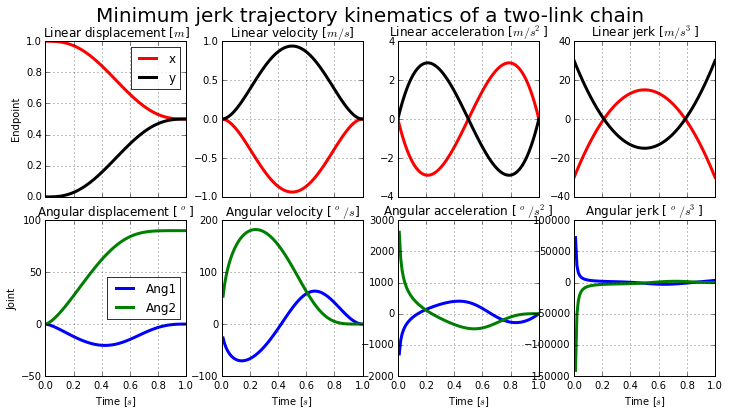

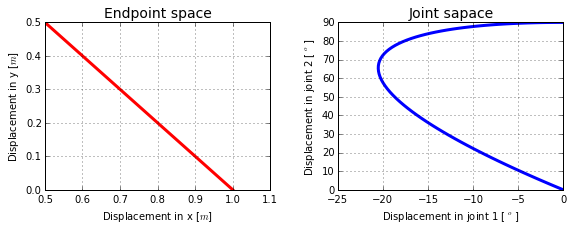

In [29]:
fig, hax = plt.subplots(2, 4, sharex = True, figsize=(12, 6))
hax[0, 0].plot(ts, x, 'r', linewidth=3, label = 'x')
hax[0, 0].plot(ts, y, 'k', linewidth=3, label = 'y')
hax[0, 0].set_title('Linear displacement [$m$]')
hax[0, 0].legend(loc='best').get_frame().set_alpha(0.8)
hax[0, 0].set_ylabel('Endpoint')
hax[0, 1].plot(ts, vx, 'r', linewidth=3)
hax[0, 1].plot(ts, vy, 'k', linewidth=3)
hax[0, 1].set_title('Linear velocity [$m/s$]')
hax[0, 2].plot(ts, ax, 'r', linewidth=3)
hax[0, 2].plot(ts, ay, 'k', linewidth=3)
hax[0, 2].set_title('Linear acceleration [$m/s^2$]')
hax[0, 3].plot(ts, jx, 'r', linewidth=3)
hax[0, 3].plot(ts, jy, 'k', linewidth=3)
hax[0, 3].set_title('Linear jerk [$m/s^3$]')
hax[1, 0].plot(ts,ang1*180/np.pi, 'b', linewidth=3, label = 'Ang1')
hax[1, 0].plot(ts,ang2*180/np.pi, 'g', linewidth=3, label = 'Ang2')
hax[1, 0].set_xlabel('Time [$s$]')
hax[1, 0].set_title('Angular displacement [ $^o$]')
hax[1, 0].legend(loc='best').get_frame().set_alpha(0.8)
hax[1, 0].set_ylabel('Joint')
hax[1, 1].plot(ts,vang1*180/np.pi, 'b', linewidth=3)
hax[1, 1].plot(ts,vang2*180/np.pi, 'g', linewidth=3)
hax[1, 1].set_xlabel('Time [$s$]')
hax[1, 1].set_title('Angular velocity [ $^o/s$]')
hax[1, 2].plot(ts,aang1*180/np.pi, 'b', linewidth=3)
hax[1, 2].plot(ts,aang2*180/np.pi, 'g', linewidth=3)
hax[1, 2].set_xlabel('Time [$s$]')
hax[1, 2].set_title('Angular acceleration [ $^o/s^2$]')
hax[1, 3].plot(ts,jang1*180/np.pi, 'b', linewidth=3)
hax[1, 3].plot(ts,jang2*180/np.pi, 'g', linewidth=3)
hax[1, 3].set_xlabel('Time [$s$]')
hax[1, 3].set_title('Angular jerk [ $^o/s^3$]')
tit = fig.suptitle('Minimum jerk trajectory kinematics of a two-link chain', fontsize=20)
for hax2 in hax.flat:
    hax2.locator_params(nbins=5)
    hax2.grid()
plt.subplots_adjust(hspace=0.15, wspace=0.25) #plt.tight_layout()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
ax1.plot(x, y, 'r', linewidth=3)
ax1.set_xlabel('Displacement in x [$m$]')
ax1.set_ylabel('Displacement in y [$m$]')
ax1.set_title('Endpoint space', fontsize=14)
ax1.grid()
ax2.plot(ang1*180/np.pi, ang2*180/np.pi, 'b', linewidth=3)
ax2.set_xlabel('Displacement in joint 1 [ $^o$]')
ax2.set_ylabel('Displacement in joint 2 [ $^o$]')
ax2.set_title('Joint sapace', fontsize=14)
plt.subplots_adjust(left=0.3, wspace=0.3)
ax2.grid()

## Problems

1. For the two-link chain, calculate and interpret the Jacobian and the expressions for the position, velocity, and acceleration of the endpoint for the following cases:   
 a) When the first joint (the joint at the base) is fixed at $0^o$.   
 b) When the second joint is fixed at $0^o$. 

2. For the two-link chain, a special case of movement occurs when the endpoint moves along a line passing through the first joint (the joint at the base). A system with this behavior is known as a polar manipulator (Mussa-Ivaldi, 1986). For simplicity, consider that the lengths of the two links are equal to $\ell$. In this case, the two joint angles are related by: $2\alpha_1+\alpha_2=\pi$.  
 a) Calculate the Jacobian for this polar manipulator and compare it with the Jacobian for the  standard two-link chain. Note the difference between the off-diagonal terms.  
 b) Calculate the expressions for the endpoint position, velocity, and acceleration.   
 c) For the endpoint acceleration of the polar manipulator, identify the tangential, centrifugal, and Coriolis components and compare them with the expressions for the standard two-link chain.

## References

- Mussa-Ivaldi FA (1986) Compliance.  In: Morasso P Tagliasco V (eds), [Human Movement Understanding: from computational geometry to artificial Intelligence](http://books.google.com.br/books?id=ZlZyLKNoAtEC). North-Holland, Amsterdam.  
- Siciliano B et al. (2009) [Robotics - Modelling, Planning and Control](http://books.google.com.br/books/about/Robotics.html?hl=pt-BR&id=jPCAFmE-logC). Springer-Verlag London.
- Zatsiorsky VM (1998) [Kinematics of Human Motions](http://books.google.com.br/books/about/Kinematics_of_Human_Motion.html?id=Pql_xXdbrMcC&redir_esc=y). Champaign, Human Kinetics.